There are two disease in potato; Early Blight and Late Blight.

We need to identify the disease by capturing photo.

collect the data -> Data cleaning and preprocessing (use tf dataset and also do data augmentation) -> Model Building (CNN) -> Export the model --> use MLOPs(use tf serving)--> FastAPI

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

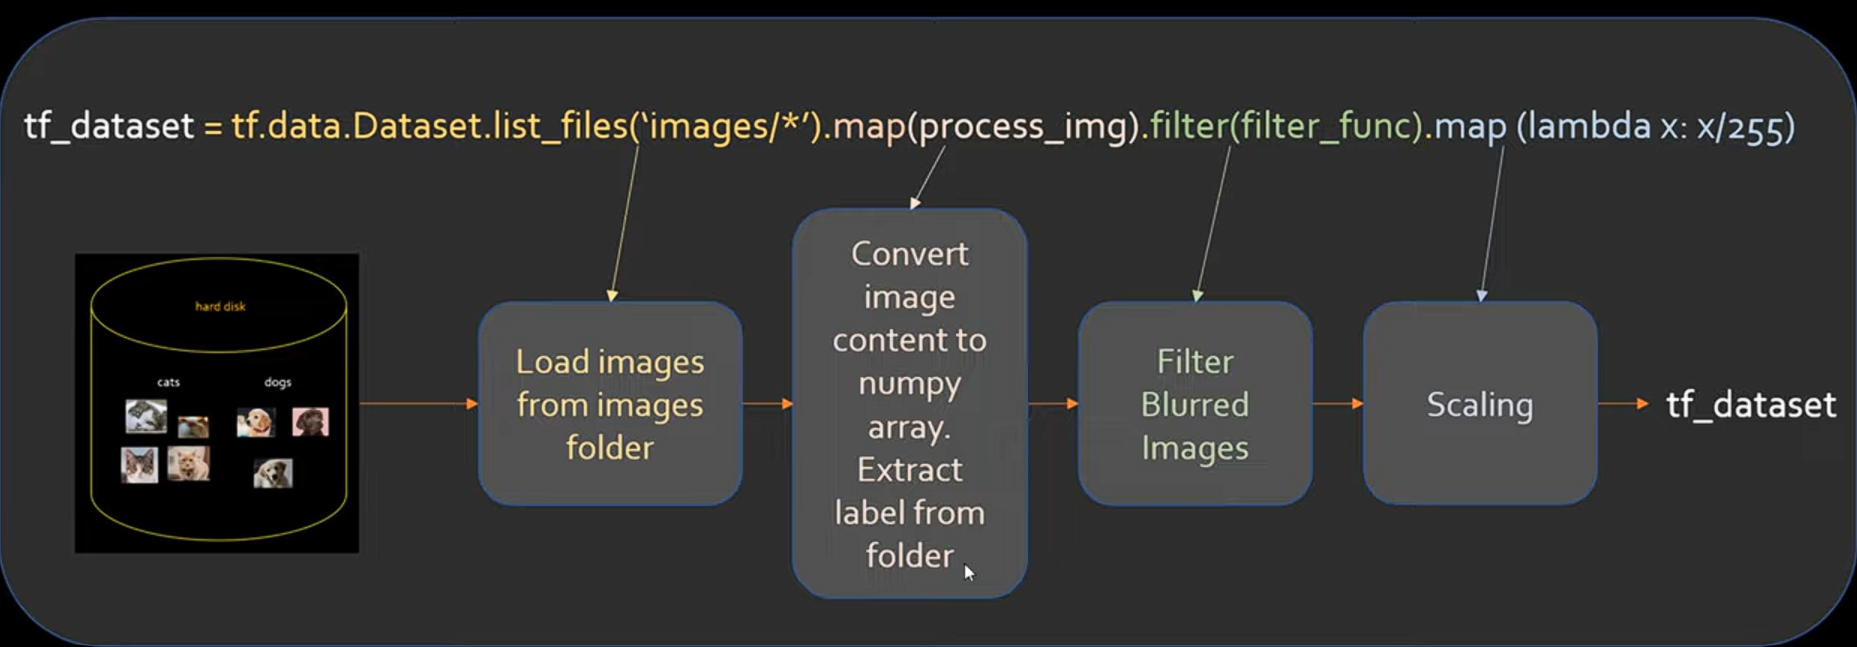

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1): # it take 1 batch that is 32 data
    print(image_batch.shape) #(total_image, width of image, height of image, color channel)
    print(labels_batch.numpy()) # image labels class

(32, 256, 256, 3)
[2 1 0 0 1 1 1 1 0 0 0 1 2 0 1 1 1 1 1 0 0 1 1 1 2 0 0 0 0 1 0 0]


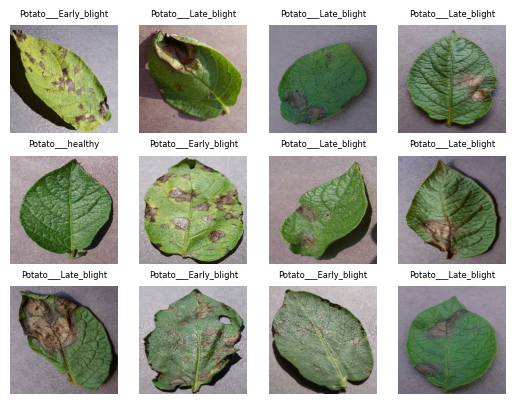

In [19]:
for image_batch, labels_batch in dataset.take(1): # it take 1 batch that is 32 data
    for i in range(12): #only 12 image is printed
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # tensor i is convert to numpy. it is in float to int
        plt.title(class_names[labels_batch[i]], fontsize=6)
        plt.axis("off")
    

Taking 80% training, 10% validation and 10% test

#### train_size =0.8
len(dataset)*train_size

In [22]:
train_ds=dataset.take(54) # take 54 batch of data for training
len(train_ds)

54

In [25]:
test_ds =dataset.skip(54) # take rest data [54:]
len(test_ds)

14

In [27]:
val_size = 0.1
print(len(dataset)*val_size)
val_ds=test_ds.take(6)  # take 6 for 10% 

6.800000000000001


In [28]:
test_dss=test_ds.skip(6)

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # assertdebugging to check if a condition is True. If the condition is False, it raises an AssertionError
    assert(train_split+test_split+val_split)==1

    ds_size = len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12) # seed same shuffle data each time  
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
len(train_ds)

54

In [41]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [44]:
#prefetch increase performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # resizing to 256*256
    layers.Rescaling(1.0/255)
])

In [48]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])